# Investigating Variable Renaming
The goal of this notebook is to understand the mechanism by which a transformer
learns to evaluate variable renamings across various depths.

### Analysis
1) Staring at attention weights
2) Patching at various depths
3) Examining embeddings

- Maybe do some SVD or PCA to visualize embeddings?

### Hypotheses
- I think the model mostly duplicates information that must be retrieved later
- The model likely guesses behind using different heads
- The model probably just attends to a bunch at the same time
- Input embeddings are likely very orthogonal

In [64]:
import torch
import numpy as np
import seaborn as sns

from iluvattnshun.utils import load_checkpoint, load_config_from_yaml
from iluvattnshun.nn import MultilayerTransformer
from iluvattnshun.viz import get_fig
from matplotlib import pyplot as plt
from torch.nn.functional import cosine_similarity

from var_rename import VariableRenamingConfig, VariableRenamingPrompter

In [ ]:
# 5 layers, 2 heads
config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_44_sweep_7/run_44_sweep_7.yaml"
ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_44_sweep_7/ckpt_epoch_239.pt"

# 5 layers, 1 head
# config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_50_sweep_3/run_50_sweep_3.yaml"
# ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_50_sweep_3/ckpt_epoch_397.pt"

# 4 layers, 2 heads
# config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_45_sweep_6/run_45_sweep_6.yaml"
# ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_45_sweep_6/ckpt_epoch_385.pt"

# 3 layers, 2 heads
# config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_48_sweep_5/run_48_sweep_5.yaml"
# ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_48_sweep_5/ckpt_epoch_495.pt"

# 2 layers, 2 head
# config_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_43_sweep_4/run_43_sweep_4.yaml"
# ckpt_path = "/home/michael-lutz/iluvattnshun/logs/var_rename/run_43_sweep_4/ckpt_epoch_764.pt"

config = load_config_from_yaml(config_path, VariableRenamingConfig)

# loading the model
max_seq_len = config.num_renames * 4
model = MultilayerTransformer(
    vocab_size=39,
    d_model=config.dim_model,
    n_heads=config.num_heads,
    n_layers=config.num_layers,
)
load_checkpoint(ckpt_path, model)
model.eval()

# loading the prompter
prompter = VariableRenamingPrompter(config)

In [66]:
rng = np.random.default_rng(42)
prompt, answer, metadata = prompter.get_prompt(rng)
x = torch.tensor(prompter.tokenize(prompt)).unsqueeze(0)
logits, kv_cache, attn_weights, _= model.forward(x, return_new_kv_cache=True, return_attn_weights=True, return_xs=True)
pred = prompter.detokenize(logits[0].argmax(dim=-1).tolist())

print("prompt: ", prompt)
print("pred:   ", pred)
print("answer: ", answer)

prompt:  2>l;0>c;1>f;3>p;c>u;u>s;s>n;p>w;l>o;o>e;n>u;f>k;u>n;e>l;w>c;k>x;c>v;n>g;x>d;g>s;l>b;s>l;l>r;r>t;v>k;b>n;k>p;p>u;d>y;y>i;t>k;n>x;x>b;b>v;u>m;m>s;v>h;s>p;i>y;h>d;k>q;y>c;d>u;q>k;k>w;u>x;x>g;c>r;p>v;v>t;t>u;w>t;r>l;l>h;t>o;g>n;h>a;u>g;g>l;a>s;n>w;s>b;o>p;b>o;o>b;b>u;w>o;l>h;o>z;h>g;z>y;p>a;g>v;v>t;y>x;x>k;u>d;d>o;a>z;o>j;k>l;z>h;t>i;i>c;c>u;j>s;l>r;u>x;s>y;x>l;y>m;r>d;d>g;g>t;m>q;t>z;l>i;i>j;h>k;k>m;q>l;z>t;m>f;f>g;l>v;t>s;s>b;j>m;g>d;b>s;m>r;s>u;v>n;r>l;d>a;a>m;n>r;u>g;r>d;d>c;c>r;l>u;g>v;u>d;v>f;f>s;d>q;q>d;r>v;d>h;m>z;v>k;s>p;k>g;h>d;z>l;p>n;l>b;d>j;n>s;s>m;b>e;g>p;m>v;v>y;y>n;p>w;n>h;j>l;e>a;
pred:    222200001111333300000000000033332222222200011111000122233333111233320002111200022222030200020303333322233233323312111211000222222223222333333333212133331011202102011011232300020001202220211211303332313333030312111112000022201313333333331013212311100000121212121212222330332023323122210101333133332323232111111111020111112111032133313231323112110211323111113332132311121112121222221

NOTE: maybe there is a pattern for how masked token predictions are made...

## Token Embeddings

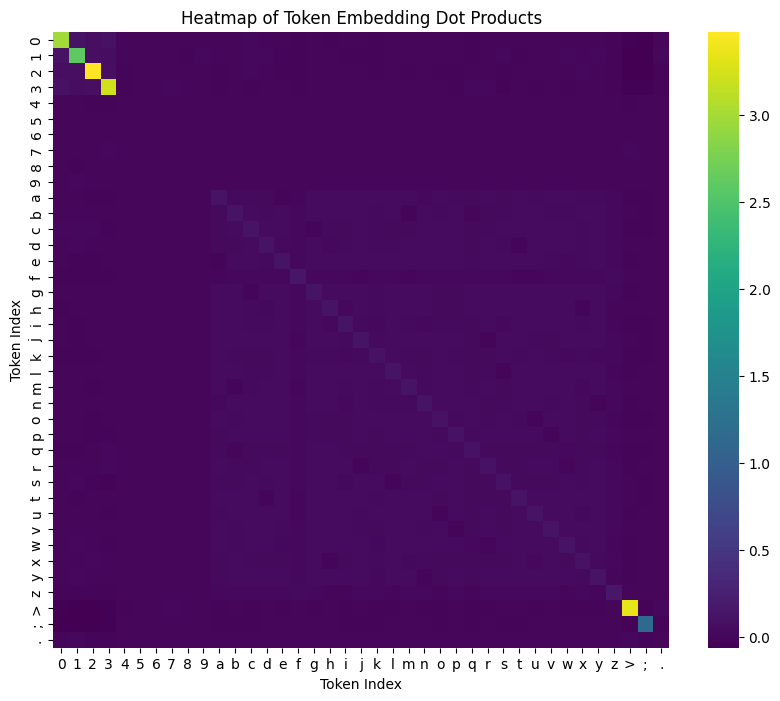

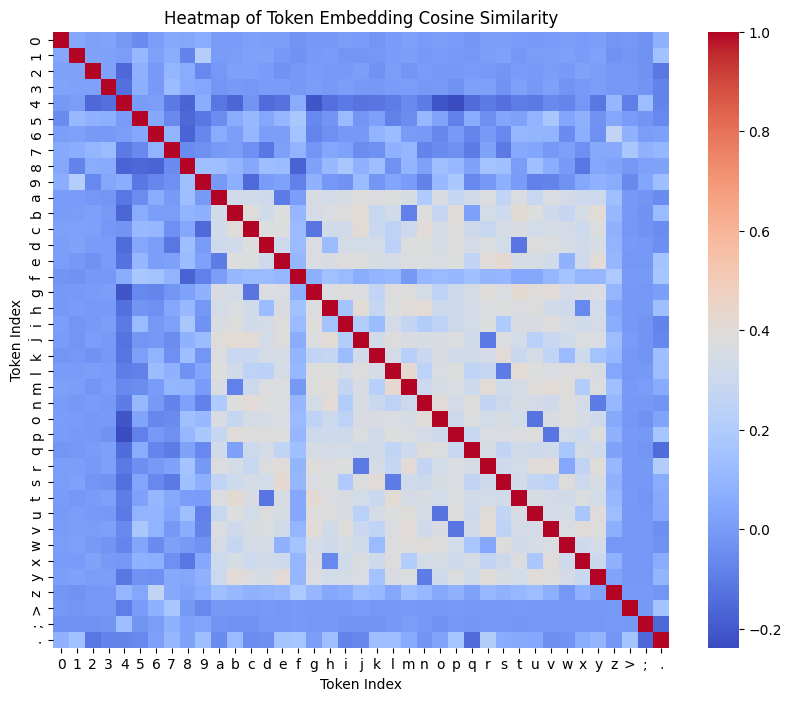

In [67]:
token_embeddings = model.token_embedding.weight.detach().cpu()  # Shape: (vocab_size, d_model)
labels = prompter.detokenize(list(range(39)))  # This will give you the token labels
dot_products = torch.matmul(token_embeddings, token_embeddings.T)  # Shape: (vocab_size, vocab_size)
cos_sim = cosine_similarity(token_embeddings.unsqueeze(0), token_embeddings.unsqueeze(1), dim=-1).squeeze(0)

plt.figure(figsize=(10, 8))
sns.heatmap(dot_products.numpy(), cmap="viridis", square=True, xticklabels=labels, yticklabels=labels)
plt.title("Heatmap of Token Embedding Dot Products")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim.numpy(), cmap="coolwarm", square=True, xticklabels=labels, yticklabels=labels)
plt.title("Heatmap of Token Embedding Cosine Similarity")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()

- `0, 1, 2, 3` are all high in magnitude (equally) as expected (~1.5)
- `>` and `;` are also high in magnitude, with `>` being the highest (~2.5)
- The alphabet is lower in magnitude ~.5, and their dot products with themselves
  are mostly .25, with some being closer to 0 or even slightly negative! Looking
  at the cosine similarity, we can see that the alphabet tokens are most similar
  to themselves, with `a` being surprisingly low. Maybe this is an artifact of a
  small-ish dataset size (1_000_000) and or prng shenanigans.
- As for why the discrepancies in cosine similarity exist. TODO: think about it

## Attention Weights
Let's take a detailed look into every attention head in the model. The goal is
to understand 1. how information propagates through layers for vairable renames
and 2. how the model is able to exceed its theoretical performance (2^4=16).

### Layer 1
- The `>` and `;` tokens attend to and are attended to by all tokens. They attend to `[0, 1, 2, 3]` more.
- a-z rarely attend to each other
- Sometimes letters will attend to the same letter in the past but not itself (depends on letter and distance)
- RoPE effect is pretty clear, leading to letters attending to the most recent `>` commonly
- **Surprisingly, in `a>b`, b will almost never attend to `a`, defying expectations**. Instead, they will commonly
  attend to the most recent `>` token. Sometimes, in the case where `...>a;a>...`, the `a` token will attend to the previous `a` token. Sometimes, in the case where `...>a;...;a>...`, this will also occur.
- Letters that directly follow a number (e.g. `2>f`) will typically *somewhat* attend to their number

In [68]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), selected_layers=[0], selected_heads=[0, 1], selected_x_toks=list(range(80)), selected_y_toks=list(range(80)))
plotly_fig.show()

### Layer 2

In [69]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), selected_layers=[1], selected_heads=[0, 1], selected_x_toks=list(range(120)), selected_y_toks=list(range(120)))
plotly_fig.show()

- Head 1 seems to just average everything with a slight bias toward `>`. While useful information could be extracted
  from this, we'll focus on the much more interesting head 2 from here on out.
- In scenarios where `a>b;...;b>c`, the second `b` will commonly attend to `a`, and the second `>` and `c` will attend
  to the most recent `b`. (TODO: think about how the second `b` finds `a` since the first `b` presumably does not attend to `a` according to the previous layer.)
- In some cases where variables are renamed immediately after their assignment (e.g. see `c>u;u` or `l>o;o`) multiple
  elements beyond the second `u` and `o` will attend to `c` and `l` respectively. This is likely because, in L1H1, the
  `u` and `o` tokens already attended to their previous selves.

### Layer 3

In [70]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), selected_layers=[2], selected_heads=[0, 1], selected_x_toks=list(range(120)), selected_y_toks=list(range(120)))
plotly_fig.show()

### Layer 4

In [71]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), selected_layers=[3], selected_heads=[0, 1], selected_x_toks=list(range(240)), selected_y_toks=list(range(240)))
plotly_fig.show()

(Write more about this, but basically we see them reach somewhere at 75% mark!)

### Layer 5

In [72]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), selected_layers=[4], selected_heads=[0, 1], selected_x_toks=list(range(240)), selected_y_toks=list(range(240)))
plotly_fig.show()

ValueError: No valid layers selected for visualization

- Head 1 is mainly averages all information stored in the ; tokens, so we can safely focus on head 2.
- We see that at early chain depth, tokens attend to themselves or nearby tokens. At higher depths, we see some of them
  attending to tokens around the middle of the origin and their positions.

In [ ]:
# weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
# plotly_fig = get_fig(weights, list(prompt), selected_layers=[0], selected_heads=[0, 1], selected_x_toks=list(range(0,601)), selected_y_toks=list(range(560,601)))
# plotly_fig.show()
